# CIC-IDS-2017 Three-Class Low-Rate DDoS Augmentation & Model Evaluation
This notebook performs:
1. Splitting the dataset by attack label into separate CSVs.
2. Basic data cleaning and inspection.
3. Preparing BENIGN, DoS slowloris, and DoS Slowhttptest subsets.
4. Designing Test scenarios with different benign vs attack ratios.
5. Evaluating MLP, Random Forest, Logistic Regression, and XGBoost under augmentation methods: None, SMOTE, ADASYN, CVAE, GAN.
6. Comparing three-class classification performance.
7. Summarizing results table and bar chart, saving data to CSV.


In [11]:
import warnings
warnings.filterwarnings('ignore')
import os, glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


In [12]:
def augment_cvae(X, y, n_samples):
    # Placeholder for CVAE-based augmentation
    return X, y

def augment_gan(X, y, n_samples):
    # Placeholder for GAN-based augmentation
    return X, y


In [13]:
# Step 1: Split by label into separate CSVs
csv_files = glob.glob('CIC-IDS-2017/*.csv')
os.makedirs('split_by_label', exist_ok=True)
for file in csv_files:
    df = pd.read_csv(file)
    df.columns = df.columns.str.strip()
    if 'Label' not in df.columns:
        raise KeyError(f"'Label' column not found in {file}.")
    for lbl, group in df.groupby('Label'):
        safe_lbl = lbl.replace('/', '_').replace(' ', '_')
        group.to_csv(f'split_by_label/{safe_lbl}.csv', index=False)
print('Split files created in split_by_label/')


Split files created in split_by_label/


In [14]:
# Step 2: Data cleaning and inspection
csv_files = glob.glob('CIC-IDS-2017/*.csv')
df_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
df_all.columns = df_all.columns.str.strip()
df_clean = df_all.drop_duplicates().dropna()
print('Original dataset shape:', df_all.shape)
print('Cleaned dataset shape:', df_clean.shape)
if 'Label' not in df_clean.columns:
    raise KeyError(f"'Label' column not found. Available: {df_clean.columns.tolist()}")
display(df_clean['Label'].value_counts())


Original dataset shape: (2830743, 79)
Cleaned dataset shape: (2522009, 79)


Label
BENIGN                        2096134
DoS Hulk                       172846
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [15]:
# Step 3: Prepare BENIGN, slowloris, and slowhttptest subsets
benign = df_clean[df_clean['Label'] == 'BENIGN']
slowloris = df_clean[df_clean['Label'] == 'DoS slowloris']
slowhttptest = df_clean[df_clean['Label'] == 'DoS Slowhttptest']
print('BENIGN samples:', len(benign))
print('DoS slowloris samples:', len(slowloris))
print('DoS Slowhttptest samples:', len(slowhttptest))


BENIGN samples: 2096134
DoS slowloris samples: 5385
DoS Slowhttptest samples: 5228


In [16]:
# Step 4: Define sampling and splitting for three‐class classification (with inf handling)

def sample_and_split(n_b, n_sl, n_sht):
    # Determine whether to sample with replacement
    rep_b   = n_b  > len(benign)
    rep_sl  = n_sl > len(slowloris)
    rep_sht = n_sht > len(slowhttptest)
    
    # Sample each class
    df = pd.concat([
        benign.sample(n=n_b,    random_state=42, replace=rep_b),
        slowloris.sample(n=n_sl, random_state=42, replace=rep_sl),
        slowhttptest.sample(n=n_sht, random_state=42, replace=rep_sht)
    ], ignore_index=True)
    
    # Replace infinities and drop any rows with NaNs
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Split features/labels
    X = df.drop(columns=['Label'])
    label_map = {'BENIGN':0, 'DoS slowloris':1, 'DoS Slowhttptest':2}
    y = df['Label'].map(label_map)
    
    # Fill any remaining NaNs in X, then standardize
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    Xs = StandardScaler().fit_transform(X)
    
    # Final stratified train/test split
    return train_test_split(Xs, y, test_size=0.3, random_state=42, stratify=y)


In [17]:
# Step 5: Define Test scenarios and models (corrected)

# Use the smaller of slowloris and slowhttptest counts as a balanced baseline
baseline_n = min(len(slowloris), len(slowhttptest))

tests = {
    'Test1': {
        'benign': baseline_n,
        'slowloris': baseline_n,
        'slowhttptest': baseline_n
    },
    'Test2': {
        'benign': len(benign),
        'slowloris': len(slowloris),
        'slowhttptest': len(slowhttptest)
    },
    'Test3': {
        'benign': baseline_n // 2,
        'slowloris': len(slowloris) // 2,
        'slowhttptest': len(slowhttptest) // 2
    },
    'Test4': {
        'benign': baseline_n * 2,
        'slowloris': len(slowloris),
        'slowhttptest': len(slowhttptest)
    }
}

methods = ['None', 'SMOTE', 'ADASYN', 'CVAE', 'GAN']

models = {
    'MLP': MLPClassifier(random_state=42, max_iter=500, early_stopping=True),
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [19]:
# Evaluate MLP for three-class classification (ADASYN safe‐guard)
results_mlp = []
for t, sz in tests.items():
    X_tr, X_te, y_tr, y_te = sample_and_split(
        sz['benign'], sz['slowloris'], sz['slowhttptest']
    )
    for m in methods:
        if m == 'SMOTE':
            X_aug, y_aug = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
        elif m == 'ADASYN':
            try:
                X_aug, y_aug = ADASYN(random_state=42).fit_resample(X_tr, y_tr)
            except ValueError:
                # no synthetic samples generated → fall back to original
                X_aug, y_aug = X_tr, y_tr
        elif m == 'CVAE':
            X_aug, y_aug = augment_cvae(X_tr, y_tr, sz['benign'])
        elif m == 'GAN':
            X_aug, y_aug = augment_gan(X_tr, y_tr, sz['benign'])
        else:
            X_aug, y_aug = X_tr, y_tr

        clf = models['MLP']
        clf.fit(X_aug, y_aug)
        y_pred = clf.predict(X_te)
        y_proba = clf.predict_proba(X_te)

        results_mlp.append({
            'Test': t,
            'Augmentation': m,
            'Model': 'MLP',
            'Accuracy': clf.score(X_te, y_te),
            'Precision': precision_score(y_te, y_pred, average='macro'),
            'Recall': recall_score(y_te, y_pred, average='macro'),
            'F1-Score': f1_score(y_te, y_pred, average='macro'),
            'ROC-AUC': roc_auc_score(y_te, y_proba, multi_class='ovo')
        })

df_mlp = pd.DataFrame(results_mlp)
display(df_mlp)
df_mlp.to_csv('mlp_threeclass_results.csv', index=False)

,Test,Augmentation,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Test1,None,MLP,0.992136,0.992140,0.992137,0.992136,0.998894
1,Test1,SMOTE,MLP,0.990436,0.990437,0.990436,0.990436,0.998652
2,Test1,ADASYN,MLP,0.992136,0.992140,0.992137,0.992136,0.998894
3,Test1,CVAE,MLP,0.992136,0.992140,0.992137,0.992136,0.998894
4,Test1,GAN,MLP,0.992136,0.992140,0.992137,0.992136,0.998894
5,Test2,None,MLP,0.999601,0.957083,0.989852,0.972614,0.997493
6,Test2,SMOTE,MLP,0.999324,0.922128,0.995396,0.956400,0.999117
7,Test2,ADASYN,MLP,0.995360,0.711856,0.985582,0.803125,0.996504
8,Test2,CVAE,MLP,0.999601,0.957083,0.989852,0.972614,0.997493
9,Test2,GAN,MLP,0.999601,0.957083,0.989852,0.972614,0.997493


In [20]:
# Evaluate Random Forest for three-class classification (ADASYN safe‐guard)
results_rf = []
for t, sz in tests.items():
    X_tr, X_te, y_tr, y_te = sample_and_split(
        sz['benign'], sz['slowloris'], sz['slowhttptest']
    )
    for m in methods:
        if m == 'SMOTE':
            X_aug, y_aug = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
        elif m == 'ADASYN':
            try:
                X_aug, y_aug = ADASYN(random_state=42).fit_resample(X_tr, y_tr)
            except ValueError:
                # no samples generated → fall back to original training set
                X_aug, y_aug = X_tr, y_tr
        elif m == 'CVAE':
            X_aug, y_aug = augment_cvae(X_tr, y_tr, sz['benign'])
        elif m == 'GAN':
            X_aug, y_aug = augment_gan(X_tr, y_tr, sz['benign'])
        else:
            X_aug, y_aug = X_tr, y_tr

        clf = models['RandomForest']
        clf.fit(X_aug, y_aug)
        y_pred = clf.predict(X_te)
        y_proba = clf.predict_proba(X_te)

        results_rf.append({
            'Test': t,
            'Augmentation': m,
            'Model': 'RandomForest',
            'Accuracy': clf.score(X_te, y_te),
            'Precision': precision_score(y_te, y_pred, average='macro'),
            'Recall': recall_score(y_te, y_pred, average='macro'),
            'F1-Score': f1_score(y_te, y_pred, average='macro'),
            'ROC-AUC': roc_auc_score(y_te, y_proba, multi_class='ovo')
        })

df_rf = pd.DataFrame(results_rf)
display(df_rf)
df_rf.to_csv('rf_threeclass_results.csv', index=False)


,Test,Augmentation,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Test1,None,RandomForest,0.996174,0.996178,0.996174,0.996174,0.999388
1,Test1,SMOTE,RandomForest,0.996174,0.996178,0.996174,0.996174,0.999395
2,Test1,ADASYN,RandomForest,0.996174,0.996178,0.996174,0.996174,0.999388
3,Test1,CVAE,RandomForest,0.996174,0.996178,0.996174,0.996174,0.999388
4,Test1,GAN,RandomForest,0.996174,0.996178,0.996174,0.996174,0.999388
5,Test2,None,RandomForest,0.999940,0.995978,0.994112,0.995043,0.998674
6,Test2,SMOTE,RandomForest,0.999946,0.995364,0.995380,0.995372,0.999329
7,Test2,ADASYN,RandomForest,0.999788,0.975528,0.975582,0.974897,0.999305
8,Test2,CVAE,RandomForest,0.999940,0.995978,0.994112,0.995043,0.998674
9,Test2,GAN,RandomForest,0.999940,0.995978,0.994112,0.995043,0.998674


In [21]:
# Evaluate Logistic Regression for three-class classification (ADASYN safe‐guard)
results_lr = []
for t, sz in tests.items():
    X_tr, X_te, y_tr, y_te = sample_and_split(
        sz['benign'], sz['slowloris'], sz['slowhttptest']
    )
    for m in methods:
        if m == 'SMOTE':
            X_aug, y_aug = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
        elif m == 'ADASYN':
            try:
                X_aug, y_aug = ADASYN(random_state=42).fit_resample(X_tr, y_tr)
            except ValueError:
                # ADASYN couldn't generate new samples, use original training set
                X_aug, y_aug = X_tr, y_tr
        elif m == 'CVAE':
            X_aug, y_aug = augment_cvae(X_tr, y_tr, sz['benign'])
        elif m == 'GAN':
            X_aug, y_aug = augment_gan(X_tr, y_tr, sz['benign'])
        else:
            X_aug, y_aug = X_tr, y_tr

        clf = models['LogisticRegression']
        clf.fit(X_aug, y_aug)
        y_pred = clf.predict(X_te)
        y_proba = clf.predict_proba(X_te)

        results_lr.append({
            'Test': t,
            'Augmentation': m,
            'Model': 'LogisticRegression',
            'Accuracy': clf.score(X_te, y_te),
            'Precision': precision_score(y_te, y_pred, average='macro'),
            'Recall': recall_score(y_te, y_pred, average='macro'),
            'F1-Score': f1_score(y_te, y_pred, average='macro'),
            'ROC-AUC': roc_auc_score(y_te, y_proba, multi_class='ovo')
        })

df_lr = pd.DataFrame(results_lr)
display(df_lr)
df_lr.to_csv('lr_threeclass_results.csv', index=False)

,Test,Augmentation,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Test1,None,LogisticRegression,0.978108,0.978231,0.978109,0.978141,0.997284
1,Test1,SMOTE,LogisticRegression,0.978108,0.978231,0.978109,0.978141,0.997279
2,Test1,ADASYN,LogisticRegression,0.978108,0.978231,0.978109,0.978141,0.997284
3,Test1,CVAE,LogisticRegression,0.978108,0.978231,0.978109,0.978141,0.997284
4,Test1,GAN,LogisticRegression,0.978108,0.978231,0.978109,0.978141,0.997284
5,Test2,None,LogisticRegression,0.998007,0.896516,0.793043,0.835605,0.984247
6,Test2,SMOTE,LogisticRegression,0.987109,0.543001,0.986933,0.642801,0.998414
7,Test2,ADASYN,LogisticRegression,0.947084,0.397963,0.739545,0.432156,0.829975
8,Test2,CVAE,LogisticRegression,0.998007,0.896516,0.793043,0.835605,0.984247
9,Test2,GAN,LogisticRegression,0.998007,0.896516,0.793043,0.835605,0.984247


In [22]:
# Evaluate XGBoost for three-class classification (ADASYN safe‐guard)
results_xgb = []
for t, sz in tests.items():
    X_tr, X_te, y_tr, y_te = sample_and_split(
        sz['benign'], sz['slowloris'], sz['slowhttptest']
    )
    for m in methods:
        if m == 'SMOTE':
            X_aug, y_aug = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
        elif m == 'ADASYN':
            try:
                X_aug, y_aug = ADASYN(random_state=42).fit_resample(X_tr, y_tr)
            except ValueError:
                # ADASYN couldn't generate new samples, fall back to original
                X_aug, y_aug = X_tr, y_tr
        elif m == 'CVAE':
            X_aug, y_aug = augment_cvae(X_tr, y_tr, sz['benign'])
        elif m == 'GAN':
            X_aug, y_aug = augment_gan(X_tr, y_tr, sz['benign'])
        else:
            X_aug, y_aug = X_tr, y_tr

        clf = models['XGBoost']
        clf.fit(X_aug, y_aug)
        y_pred = clf.predict(X_te)
        y_proba = clf.predict_proba(X_te)

        results_xgb.append({
            'Test': t,
            'Augmentation': m,
            'Model': 'XGBoost',
            'Accuracy': clf.score(X_te, y_te),
            'Precision': precision_score(y_te, y_pred, average='macro'),
            'Recall': recall_score(y_te, y_pred, average='macro'),
            'F1-Score': f1_score(y_te, y_pred, average='macro'),
            'ROC-AUC': roc_auc_score(y_te, y_proba, multi_class='ovo')
        })

df_xgb = pd.DataFrame(results_xgb)
display(df_xgb)
df_xgb.to_csv('xgb_threeclass_results.csv', index=False)

,Test,Augmentation,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Test1,None,XGBoost,0.995962,0.995963,0.995962,0.995962,0.999702
1,Test1,SMOTE,XGBoost,0.995537,0.995538,0.995537,0.995537,0.999756
2,Test1,ADASYN,XGBoost,0.995962,0.995963,0.995962,0.995962,0.999702
3,Test1,CVAE,XGBoost,0.995962,0.995963,0.995962,0.995962,0.999702
4,Test1,GAN,XGBoost,0.995962,0.995963,0.995962,0.995962,0.999702
5,Test2,None,XGBoost,0.999949,0.995572,0.995606,0.995586,0.999764
6,Test2,SMOTE,XGBoost,0.999929,0.992249,0.994364,0.993296,0.999851
7,Test2,ADASYN,XGBoost,0.999661,0.960216,0.959916,0.958135,0.999033
8,Test2,CVAE,XGBoost,0.999949,0.995572,0.995606,0.995586,0.999764
9,Test2,GAN,XGBoost,0.999949,0.995572,0.995606,0.995586,0.999764


,Test,Augmentation,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Test1,NaN,MLP,0.992136,0.992140,0.992137,0.992136,0.998894
1,Test1,SMOTE,MLP,0.990436,0.990437,0.990436,0.990436,0.998652
2,Test1,ADASYN,MLP,0.992136,0.992140,0.992137,0.992136,0.998894
3,Test1,CVAE,MLP,0.992136,0.992140,0.992137,0.992136,0.998894
4,Test1,GAN,MLP,0.992136,0.992140,0.992137,0.992136,0.998894
...,...,...,...,...,...,...,...,...
75,Test4,NaN,XGBoost,0.996361,0.996097,0.995305,0.995698,0.999680
76,Test4,SMOTE,XGBoost,0.996044,0.995888,0.994880,0.995381,0.999577
77,Test4,ADASYN,XGBoost,0.986392,0.983269,0.982416,0.982540,0.999526
78,Test4,CVAE,XGBoost,0.996361,0.996097,0.995305,0.995698,0.999680


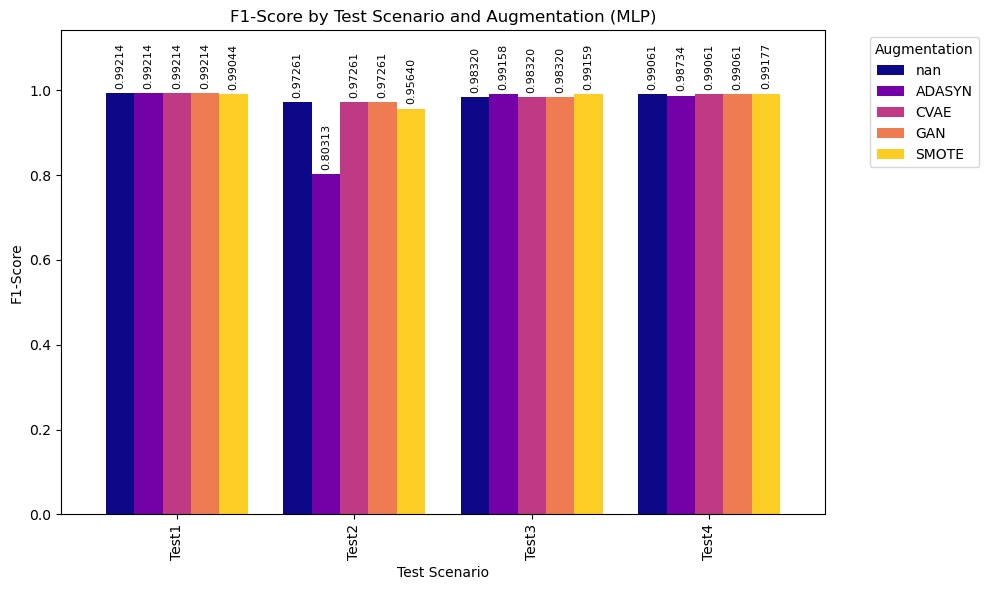

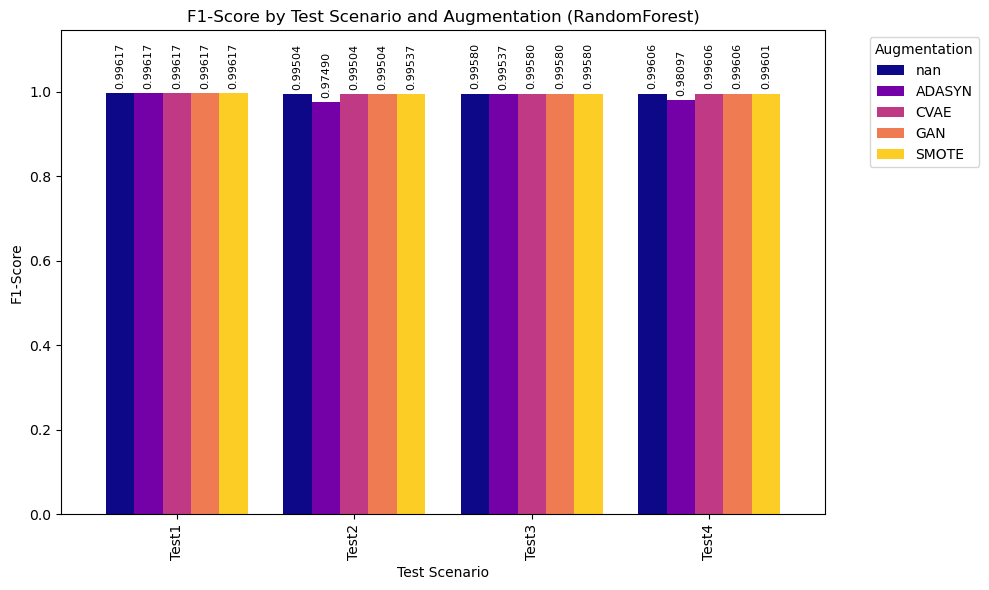

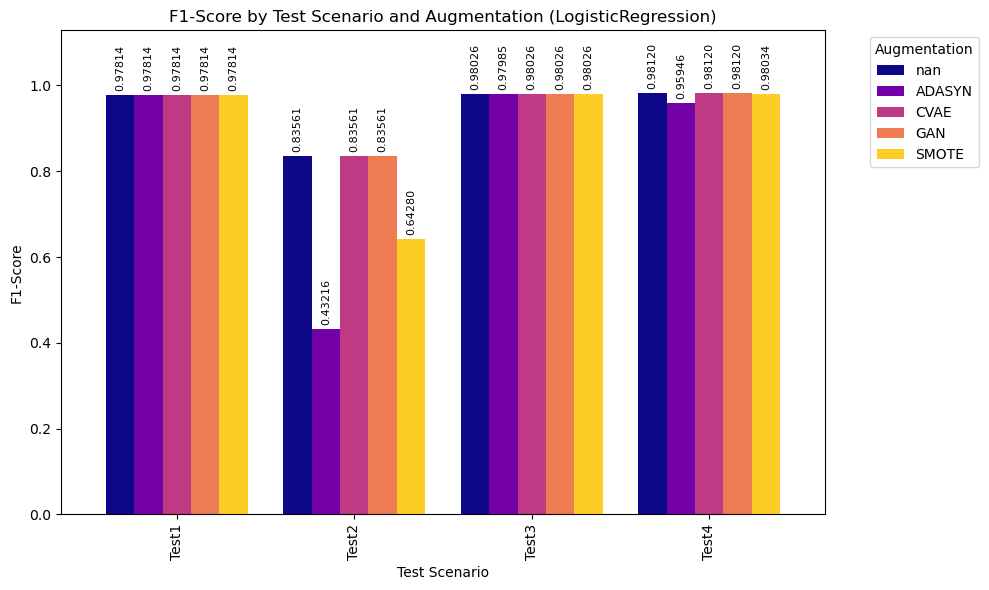

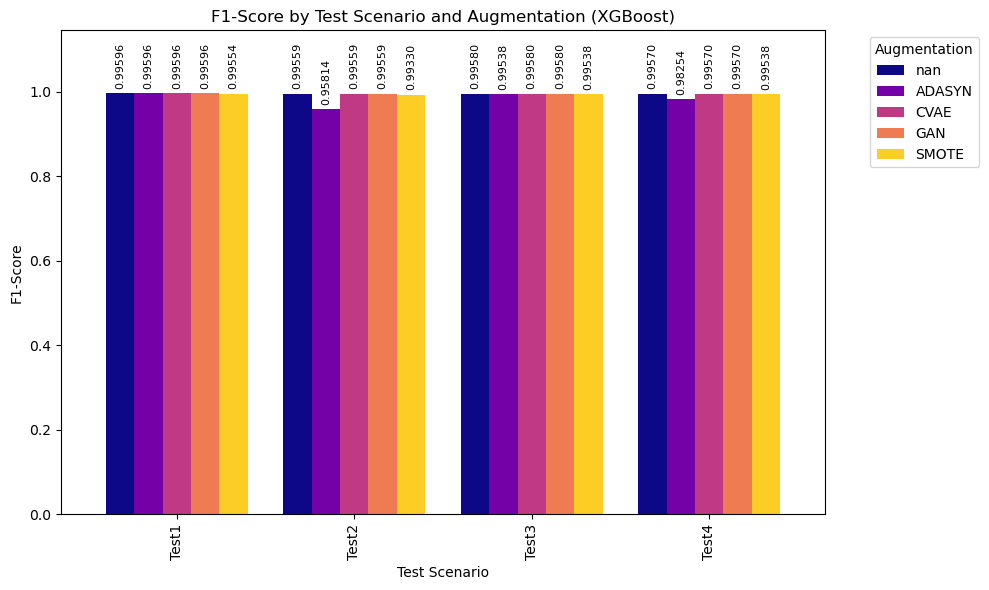

In [36]:
# Summary: Combine all results, save and visualize
df_mlp = pd.read_csv('mlp_threeclass_results.csv')
df_rf  = pd.read_csv('rf_threeclass_results.csv')
df_lr  = pd.read_csv('lr_threeclass_results.csv')
df_xgb = pd.read_csv('xgb_threeclass_results.csv')
df_all = pd.concat([df_mlp, df_rf, df_lr, df_xgb], ignore_index=True)
df_all.to_csv('threeclass_results.csv', index=False)
display(df_all)




# For each model, plot F1-Score across Test scenarios for each augmentation
for model in df_all['Model'].unique():
    subset = df_all[df_all['Model'] == model]
    pivot = subset.pivot(index='Test', columns='Augmentation', values='F1-Score')
    
    # Sample a consistent set of 5 plasma colors (avoiding the very brightest)
    cmap = plt.get_cmap('plasma')
    colors = [cmap(x) for x in np.linspace(0, 0.9, len(pivot.columns))]
    
    # Create bar plot using the custom colors
    ax = pivot.plot(
        kind='bar',
        color=colors,
        figsize=(10, 6),
        width=0.8
    )
    ax.set_title(f'F1-Score by Test Scenario and Augmentation ({model})')
    ax.set_ylabel('F1-Score')
    ax.set_xlabel('Test Scenario')
    ax.legend(title='Augmentation', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Extend y-axis for annotation space
    max_val = pivot.values.max()
    ax.set_ylim(0, max_val * 1.15)
    
    # Annotate each bar with its value (5 decimal places), vertical orientation
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f'{height:.5f}',
            xy=(p.get_x() + p.get_width() / 2, height),
            xytext=(0, 3),
            textcoords='offset points',
            ha='center',
            va='bottom',
            rotation='vertical',
            fontsize=8
        )
    
    plt.tight_layout()
    plt.show()


In [37]:
from sklearn.metrics import classification_report, confusion_matrix

# Get classification report
report = classification_report(y_te, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_te, y_pred)

# Extract per-class F1 and recall
f1_benign = report['0']['f1-score']
f1_slowloris = report['1']['f1-score']
f1_slowhttptest = report['2']['f1-score']

recall_benign = report['0']['recall']
recall_slowloris = report['1']['recall']
recall_slowhttptest = report['2']['recall']

# Average recall of attack classes
recall_attack_avg = (recall_slowloris + recall_slowhttptest) / 2

# Append extended results
results_mlp.append({
    'Test': t,
    'Augmentation': m,
    'Model': 'MLP',
    'TrainSize': len(X_aug),
    'Accuracy': clf.score(X_te, y_te),
    'Precision': precision_score(y_te, y_pred, average='macro'),
    'Recall': recall_score(y_te, y_pred, average='macro'),
    'F1-Score': f1_score(y_te, y_pred, average='macro'),
    'F1-BENIGN': f1_benign,
    'F1-Slowloris': f1_slowloris,
    'F1-Slowhttptest': f1_slowhttptest,
    'Recall-ATTACK-AVG': recall_attack_avg
})

# Optional: print for interactive inspection
print(f"=== Test: {t} | Aug: {m} ===")
print("Confusion Matrix:\n", cm)
print("Per-Class Report:\n", classification_report(y_te, y_pred, digits=4))

=== Test: Test4 | Aug: GAN ===
Confusion Matrix:
 [[3135    0    1]
 [   6 1602    8]
 [   3    5 1560]]
Per-Class Report:
               precision    recall  f1-score   support

           0     0.9971    0.9997    0.9984      3136
           1     0.9969    0.9913    0.9941      1616
           2     0.9943    0.9949    0.9946      1568

    accuracy                         0.9964      6320
   macro avg     0.9961    0.9953    0.9957      6320
weighted avg     0.9964    0.9964    0.9964      6320

